<a href="https://colab.research.google.com/github/wonseokb/Genat4_Study/blob/main/6_NN_Task1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading

Let us start by loading seismic data and a picked horizon. For simplicity, we will start with the sea floor.

In [ ]:
!pip install segpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 3.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=31a5ff0136550dd32917ec3fde2d9061feb91d6e2ab1b53afa19b931ce2e3730
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!wget url_to_file # to download a file to the current server that you are running the notebook on

!unzip filename # unzip the zip file (if necessary)

Mounted at /content/drive
--2023-02-26 07:37:45--  http://url_to_file/
Resolving url_to_file (url_to_file)... failed: Name or service not known.
wget: unable to resolve host address ‘url_to_file’
unzip:  cannot find or open filename, filename.zip or filename.ZIP.


In [ ]:
import os
from segpy.reader import create_reader

# this file is available from: https://www.dropbox.com/s/680edyveewojcxn/class2021_16_bit.sgy

# from google.colab import drive
# drive.mount('/content/gdrive')
# change the directory name below to your local path
# dirname = '/content/gdrive/MyDrive'
dirname = '/content/drive/My Drive/' # change path to your local path, of course
filename = 'class2021_16_bit.sgy'

#dirname = '/users/sergey/Downloads'
# Seismic data resampled to 16-bit SEGY format
#filename = 'class2021_16_bit.sgy'
segy = open(os.path.join(dirname, filename), 'rb')
reader = create_reader(segy)
print(reader.num_traces())  # check number of traces

INFO:segpy.reader:Successfully unpickled reader for /content/drive/My Drive/class2021_16_bit.sgy


697761


The code above should output <code>697761</code>. 

In [ ]:
import numpy as np

# get cube dimensions
nt = reader.max_num_trace_samples()  # samples in a trace
n_inlines = reader.num_inlines()  # number of inlines
n_xlines = reader.num_xlines()  # number of crosslines
print(nt, n_inlines, n_xlines)


def read_slice(inline):
    'read one inline slice'
    section = np.zeros((nt, n_xlines))
    for i in range(n_xlines):
        section[:, i] = reader.trace_samples(inline*n_xlines + i)
    return section

2001 1161 601


The seismic cube size in (time,inline,crossline) coordinates is (2001,1161,601). Let us display one inline section.

In [ ]:
import matplotlib.pyplot as plt

dt = 0.004  # time sampling in seconds
dx = 0.025  # trace sampling in kilometers


def plot_seismic(section):
    plt.imshow(section, cmap='gray', vmin=-2000, vmax=2000, aspect=0.5)
    yticks = np.arange(0, section.shape[0], 250)
    ytick_labels = [str(dt*k) for k in yticks]
    plt.yticks(ticks=yticks, labels=ytick_labels)
    plt.ylabel('two-way traveltime (s)', fontsize=14)
    xticks = np.arange(0, section.shape[1], 100)
    xtick_labels = [str(dx*k) for k in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.xlabel('distance (km)', fontsize=14)

Next, let us load and display the seafloor horizon.

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/seafloor_XY_il_cl.csv'

df = pd.read_csv(url, names=['x', 'y', 'il', 'xl', 'z'])
df.tail()

,x,y,il,xl,z
697693,405251.32,3234671.92,2030,7066,400.316566
697694,405269.58,3234689.00,2030,7067,399.911404
697695,405287.83,3234706.09,2030,7068,399.521232
697696,405306.09,3234723.17,2030,7069,399.086058
697697,405324.34,3234740.25,2030,7070,398.660868


In [ ]:
min_il = df['il'].min()  # minimum inline number
max_il = df['il'].max()  # maximum inline number

min_xl = df['xl'].min()  # minimum crossline number
max_xl = df['xl'].max()  # maximum crossline number

# load horizon in a 2D numpy array
z = np.zeros((n_inlines, n_xlines))

il_ind = df['il'][:] - min_il
xl_ind = df['xl'][:] - min_xl
z[il_ind, xl_ind] = df['z'][:]

In [ ]:
# fill in the surface where there is no valid data:
zero_row, zero_col = np.where(z == 0)  # find locations where z = 0
for i in range(len(zero_row)):
    patch = z[zero_row[i] - 2: zero_row[i] + 3, zero_col[i] -
              2: zero_col[i] + 3]  # patch of 5x5 pixels
    # take the mean of nonzero neighbors
    z[zero_row[i], zero_col[i]] = np.mean(patch[patch != 0])

To verify the horizon pick, let us display it on top of
a seismic section.

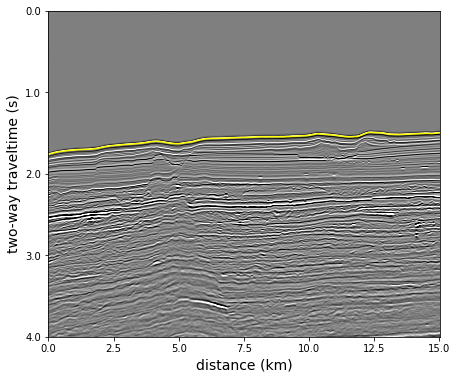

In [ ]:
def plot_section(iline):
    section = read_slice(iline)[:1001]  # window top half
    seafloor = z[iline, :]
    plt.figure(figsize=(15, 6))
    plot_seismic(section)
    plt.plot(seafloor/(dt*1000), color='yellow')
    plt.show()


plot_section(500)

## Extracting Seismic Wavelets

Our goal is to teach the computer to pick a horizon automatically. To do that, we are going to extract seismic wavelets centered at the seafloor and compare them with wavelets from elsewhere in the section.

In [ ]:
# select one 2D section
section = read_slice(500)
seafloor = z[500, :]

nw = 21  # set wavelet length ##Task1-1-1

sf_wavelets = []
ntraces = len(seafloor)
for k in range(ntraces):
    trace = section[:, k]
    # convert miliseconds to index
    center = int(np.rint(seafloor[k]/(dt*1000)))
    # extract wavelet centered at seafloor
    wavelet = trace[center-nw//2:center+nw//2+1]
    sf_wavelets.append(wavelet)

Let us plot some seafloor wavelets to observe their shape.

In [ ]:
def plot_wavelets(wavelets, traces, title):
    nw = len(wavelets[0])
    ncols = len(traces)
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
    twt = np.arange(-nw//2+1, nw//2+1)*dt
    for trace in range(ncols):
        axt = ax[trace]
        # plot as curve
        amp = wavelets[traces[trace]]
        axt.plot(amp, twt, 'k')
        axt.set_ylim(twt.max(), twt.min())
        if trace == 0:
            axt.set_ylabel('Time (s)')
        else:
            axt.set_yticklabels([])
        axt.set_xticks([])
    f.suptitle(title, fontsize=25)
    plt.show()

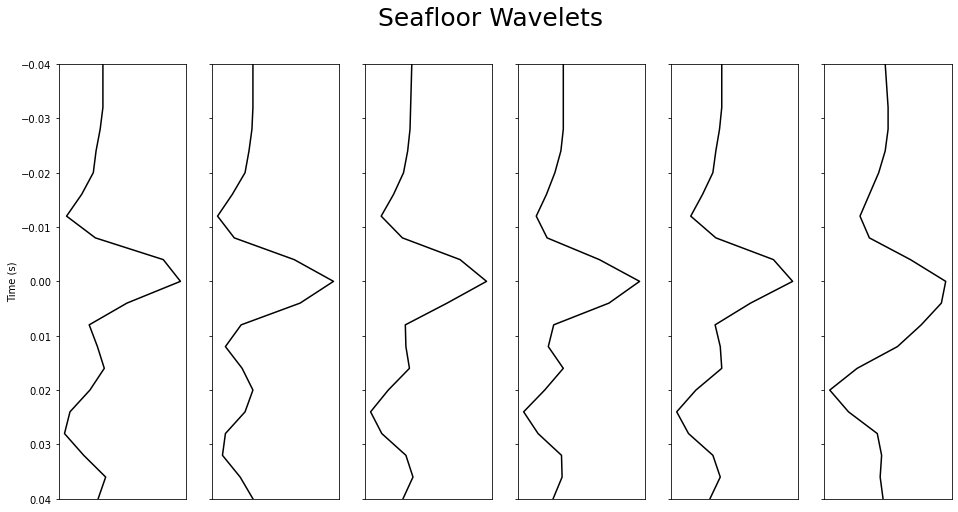

In [ ]:
plot_wavelets(sf_wavelets,np.arange(100,601,100),
             'Seafloor Wavelets')

To train our model, we will also randomly extract wavelets from elsewhere in the section. For proper training, we will extract 10 times more other wavelets.

## <span style="color:red">Task 1</span>

There are several ways to improve the results.

2. Use more training data.

For example:

- Generate more cases of non-seafloor wavelets by increasing the parameter called <code>cases</code>.
- Collect seafloor and non-seafloor wavelets for training from more than one section.

In [ ]:
import random
random.seed(2023)

wavelets = []
cases = 20 #Task1-2-1
for k in range(ntraces):
    trace = section[:,k]
    sf=int(np.rint(seafloor[k]/(dt*1000)))
    for case in range(cases):
        # select center randomly
        center=random.randint(nw,nt-nw)
        # make sure it is not at the seafloor
        while center==sf:
            center=random.randint(nw,nt-nw)
        # extract wavelet
        wavelet=trace[center-nw//2:center+nw//2+1]
        wavelets.append(wavelet)

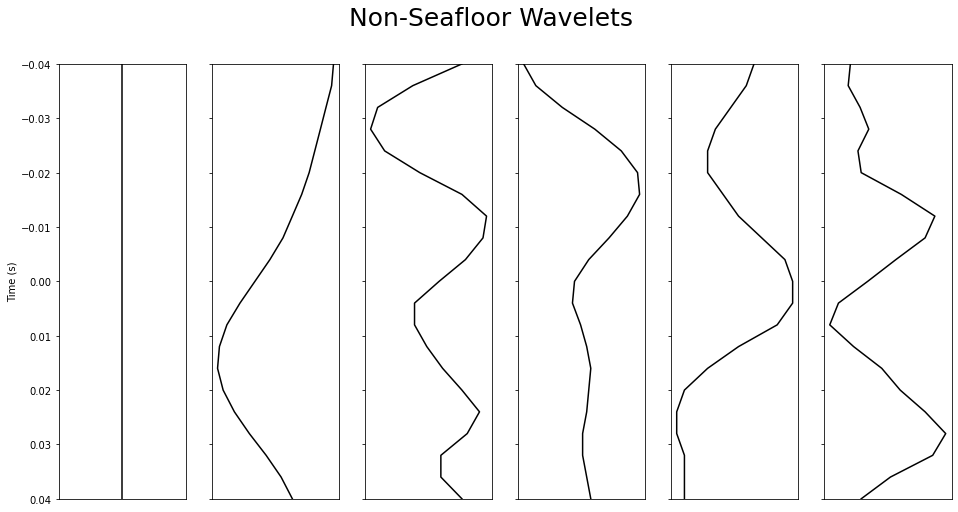

In [ ]:
plot_wavelets(wavelets,np.arange(1000,6001,900),
             'Non-Seafloor Wavelets')

A human can be easily trained to dinstinguish between seafloor and non-seafloor wavelets. To teach the computer to do that, we will build a model using neural networks.

We will be using **Keras** in today's example.

## Designing a Neural Network

Let us first collect data from seafloor and non-seafloor wavelets.

In [ ]:
random.seed(2023)

all_wavelets = sf_wavelets+wavelets
random.shuffle(all_wavelets)
data = np.array(all_wavelets)
data.shape

(12621, 21)

In [ ]:
# normalize data
scale = 1.0/5000  #Task1-1-2
data = data*scale

For training, we will label seafloor wavelets as 1 and non-seafloor wavelets as 0. 

In [ ]:
random.seed(2023)

indicators = [1]*len(sf_wavelets)+[0]*len(wavelets)
random.shuffle(indicators)
labels = np.array(indicators)
labels.shape

(12621,)

Our network will contain one hidden layer, which will transfer its output to classification.

In [ ]:
from tensorflow import keras
import tensorflow.random

# for reproducibility
tensorflow.random.set_seed(2023)
np.random.seed(2023)

model = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [ ]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 176       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


Mathematically, the model can be represented as follows:

$$y = s\left(a_2 + \mathbf{b}_2^{T}\,r\left(\mathbf{a}_1 + \mathbf{B}_1^{T}\,\mathbf{x}\right)\right)\;.$$

Here $\mathbf{x}$ is an input (21-dimensional vector), $y$ is a scalar output (probability of seafloor).

The network sandwiches linear and non-linear operations. The non-linear activation functions are $r(z)$ for ReLU and $s(z)$ for sigmoid.

The parameters of the model are $\mathbf{B}_1$ ($21 \times 8$ matrix), $\mathbf{a}_1$ (8-dimensional vector), $\mathbf{b}_2$ (8-dimensional vector), and $a_2$ (a scalar). The total number of parameters is
$$21 \times 8 + 8 + 8 + 1 = 185\;.$$

In [ ]:
21*8+8+8+1

185

To train the model, we will ask it to use the Adam optimizer and the cross-entropy loss function. We will also ask it to track the prediction accuracy (the percentage of accurate preductions).

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training the Model

Because we have only few seafloor wavelets compared to the number of other wavelets, we would need to scale them differently to avoid bias. 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',classes=[0,1],
                               y=labels)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.525, 1: 10.5}


Finally, we are ready to train the model. Note that Keras handles splitting the data into training and validation internally during training.

In [ ]:
# fit the model
batch_size=10
epochs=15
fit = model.fit(data,labels,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
884/884 [==============================] - 8s 7ms/step - loss: 0.3320 - accuracy: 0.9948 - val_loss: 0.0625 - val_accuracy: 0.9947
Epoch 2/15
884/884 [==============================] - 8s 9ms/step - loss: 0.0471 - accuracy: 0.9964 - val_loss: 0.0200 - val_accuracy: 0.9955
Epoch 3/15
884/884 [==============================] - 3s 4ms/step - loss: 0.0162 - accuracy: 0.9968 - val_loss: 0.0125 - val_accuracy: 0.9966
Epoch 4/15
884/884 [==============================] - 3s 3ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0104 - val_accuracy: 0.9966
Epoch 5/15
884/884 [==============================] - 3s 3ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0086 - val_accuracy: 0.9966
Epoch 6/15
884/884 [==============================] - 4s 4ms/step - loss: 0.0047 - accuracy: 0.9980 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 7/15
884/884 [==============================] - 3s 3ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0052 - val_accuracy: 0.9982
Epoch 

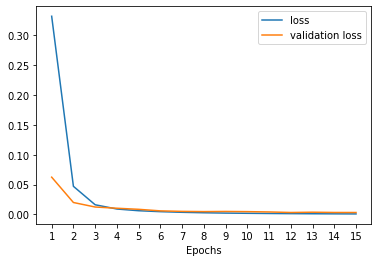

In [ ]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

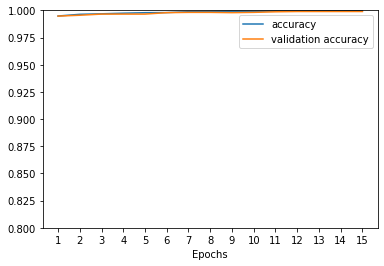

In [ ]:
def plot_accuracy(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    plt.ylim(0.8, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(fit, epochs)

###Generate more cases of non-seafloor wavelets by increasing the parameter called cases.

---> This makes better result